# Optics calculation and matching for a large ring (LHC) - part 1

%matplotlib widget

In [1]:
import xtrack as xt

import numpy as np
import matplotlib.pyplot as plt
import os

from util.constants import HLLHC15_THICK_PATH, OPT_150_1500_PATH

### Load LHC model

In [2]:
collider = xt.Multiline.from_json(HLLHC15_THICK_PATH)
collider.vars.load_madx_optics_file(OPT_150_1500_PATH)

collider.build_trackers()

Loading line from dict: 100%|██████████| 29009/29009 [00:01<00:00, 22804.23it/s]


Done loading line from dict.           


### Initial twiss

In [3]:
tw0 = collider.lhcb1.twiss()

                                             
Optimize - start penalty: 1.762e-08

Optimize - end penalty:  1.30577e-14
                                             
Optimize - start penalty: 1.734e-08

Optimize - end penalty:  1.81697e-15


In [4]:
# Inspect IPS
tw0.rows['ip.*'].cols['betx bety mux muy x y']

TwissTable: 9 rows, 7 cols
name            betx          bety           mux           muy             x             y
ip1             0.15          0.15             0             0             0             0
ip2               10            10       8.23376        7.6927  -1.85096e-18  -1.44445e-34
ip3          121.567       218.584       15.9494       15.4503   6.91384e-16  -6.43523e-35
ip4           236.18       306.197        23.507       22.3832  -4.60828e-16   5.83486e-34
ip5             0.15          0.15       30.9305       29.9889   1.34925e-17   1.01359e-35
ip6          273.434        183.74       38.7487       37.3936    4.0662e-16    3.7598e-34
ip7          120.813       149.431       46.3524       44.5934  -1.37417e-16  -9.06447e-34
ip8              1.5           1.5       54.3432       52.2729  -3.49427e-17   3.46667e-33
ip1.l1          0.15          0.15         62.31         60.32  -7.49865e-18   1.39821e-33

### Prepare for optics matching: set limits and steps for all circuits

In [5]:
import lhc_match as lm
lm.set_var_limits_and_steps(collider)

In [6]:
# Inspect for one circuit
collider.vars.vary_default['kq4.l2b2']

{'step': 1e-06, 'limits': (0.00020557714282348692, 0.0068525714274495645)}

### Twiss on a part of the machine (bidirectional)

In [7]:
tw_81_12 = collider.lhcb1.twiss(start='ip8', end='ip2', init_at='ip1',
                                betx=0.15, bety=0.15)

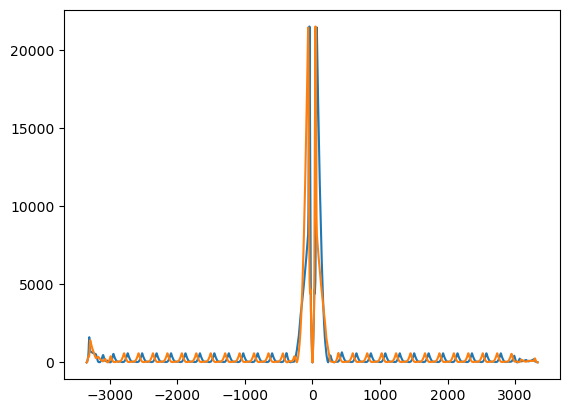

In [8]:
plt.figure()
plt.plot(tw_81_12.s, tw_81_12.betx)
plt.plot(tw_81_12.s, tw_81_12.bety)

### Telescopic rematch of IP1 using IP2 and IP8

#### Match left side

#### Define Optimizer and Merit Function

In [9]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='s.ds.l8.b1', end='ip1',
    init=tw0, init_at=xt.START,
    vary=[
        # Only IR8 quadrupoles including DS
        xt.VaryList(['kq6.l8b1', 'kq7.l8b1', 'kq8.l8b1', 'kq9.l8b1', 'kq10.l8b1', 
            'kqtl11.l8b1', 'kqt12.l8b1', 'kqt13.l8b1',
            'kq4.l8b1', 'kq5.l8b1', 'kq4.r8b1', 'kq5.r8b1', 
            'kq6.r8b1', 'kq7.r8b1', 'kq8.r8b1', 'kq9.r8b1', 
            'kq10.r8b1', 'kqtl11.r8b1', 'kqt12.r8b1', 'kqt13.r8b1'])],
    targets=[
        xt.TargetSet(at='ip8', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetSet(at='ip1', betx=0.15, bety=0.1, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'ip1.l1'] - tw0['mux', 's.ds.l8.b1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'ip1.l1'] - tw0['muy', 's.ds.l8.b1']), 
    ])

In [10]:
merit_function = opt.get_merit_function(return_scalar=False, check_limits=False)
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

In [11]:
opt.target_status()

Target status:                          
id state tag tol_met       residue   current_val    target_val description                                 
0  ON           True  -4.50736e-10           1.5           1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
1  ON           True  -5.73919e-11           1.5           1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
2  ON           True   1.92585e-10   2.20526e-07   2.20333e-07 line=lhcb1, ('alfx', 'ip8'), val=2.20333 ...
3  ON           True   1.87368e-12   2.15516e-07   2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
4  ON           True   6.97608e-10   1.88725e-09   1.18964e-09 line=lhcb1, ('dx', 'ip8'), val=1.18964e- ...
5  ON           True   1.16554e-09   1.32257e-09   1.57025e-10 line=lhcb1, ('dpx', 'ip8'), val=1.57025e ...
6  ON           True  -5.42685e-08          0.15          0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
7  ON          False          0.05          0.15           0.1 line=lhcb1, ('bety', 'ip1'), val

In [11]:
len_arrays = []
for i in range(20):
    opt.solve_homotopy(n_steps=i)
    len_arrays.append(merit_function.merit_function.call_counter)
    opt.reload(0)
    merit_function.merit_function.call_counter = 1

Matching: model call n. 443               

Matching: model call n. 189               

Matching: model call n. 477               

Matching: model call n. 161               

Matching: model call n. 323               

Matching: model call n. 510               

Matching: model call n. 115               

Matching: model call n. 255               

Matching: model call n. 417               

Matching: model call n. 579               

Matching: model call n. 115               

Matching: model call n. 231               

Matching: model call n. 347               

Matching: model call n. 487               

Matching: model call n. 649               

Matching: model call n. 89                

Matching: model call n. 181               

Matching: model call n. 297               

Matching: model call n. 413               

Matching: model call n. 551               

Matching: model call n. 713               

Matching: model call n. 67                

Matching: model call n. 135     

In [17]:
opt.solve_homotopy(n_steps=20)
len_arrays.append(merit_function.merit_function.call_counter)
opt.reload(0)
merit_function.merit_function.call_counter = 1

Matching: model call n. 67               

Matching: model call n. 135               

Matching: model call n. 203               

Matching: model call n. 271               

Matching: model call n. 339               

Matching: model call n. 407               

Matching: model call n. 475               

Matching: model call n. 543               

Matching: model call n. 611               

Matching: model call n. 679               

Matching: model call n. 747               

Matching: model call n. 815               

Matching: model call n. 883               

Matching: model call n. 951               

Matching: model call n. 1019               

Matching: model call n. 1087               

Matching: model call n. 1155               

Matching: model call n. 1223               

Matching: model call n. 1291               

Matching: model call n. 1359               



In [18]:
len_arrays

[445,
 479,
 512,
 581,
 651,
 715,
 689,
 729,
 749,
 747,
 859,
 949,
 951,
 1019,
 1043,
 1133,
 1179,
 1225,
 1315,
 1361]

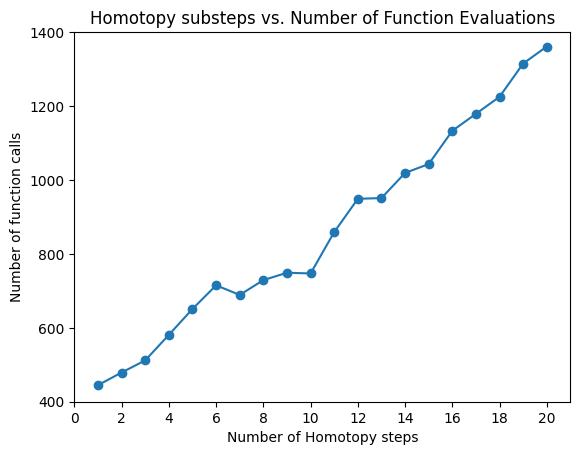

In [42]:
plt.plot(np.arange(1, 21), len_arrays, marker="o")
plt.title("Homotopy substeps vs. Number of Function Evaluations")
plt.ylabel("Number of function calls")
plt.ylim(400, 1400)
plt.xlim(0, 21)
plt.xticks(np.arange(0, 21, 2))
plt.xlabel("Number of Homotopy steps")
plt.show()

In [ ]:
knobs = np.array(opt._log['knobs']).T

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(15,20))
for i in range(len(knobs)):
    ax = axes[i // 4][i % 4]
    ax.plot(knobs[i])
plt.tight_layout()

In [ ]:
def solve_homotopy(n_steps=10):
    t = np.linspace(0, 1, n_steps + 1)[1:]
    A = opt._err.last_res_values
    B = np.array([opt.targets[i].value for i in range(len(opt.targets))])

    # Main Loop
    for i in range(n_steps):
        C = (1-t[i]) * A + t[i] * B
        # Setting targets according to C
        for oldtar, newval in zip(opt.targets, C):
            oldtar.value = newval
        
        print(f"t = {t[i]}")

        try:
            opt.solve()
        except RuntimeError:
            print("Reverting values")
            # Reload doesn't bring back the targets, but is it needed?
            opt.reload(tag=f"Homotopy it {i-1}")
            return

        opt.tag(f"Homotopy it {i}")

In [ ]:
solve_homotopy(5)

In [ ]:
opt.log()

In [ ]:
opt.reload(tag="Homotopy it 2")

#### Match right side

In [ ]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='ip1', end='e.ds.r2.b1',
    init=tw0, init_at=xt.END, # <-- We match going backward in the line
    vary=[
        xt.VaryList([
            'kq9.l2b1', 'kq10.l2b1', 'kqtl11.l2b1', 'kqt12.l2b1', 'kqt13.l2b1',
            'kq9.r2b1', 'kq10.r2b1', 'kqtl11.r2b1', 'kqt12.r2b1', 'kqt13.r2b1',
            'kq4.l2b1', 'kq5.l2b1',  'kq6.l2b1', 'kq7.l2b1', 'kq8.l2b1',
            'kq6.r2b1',  'kq7.r2b1', 'kq8.r2b1', 'kq4.r2b1', 'kq5.r2b1'])],
    targets=[
        # Only IR2 quadrupoles including DS
        xt.TargetSet(at='ip1', betx=0.15, bety=0.10, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetSet(at='ip2', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'e.ds.r2.b1'] - tw0['mux', 'ip1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'e.ds.r2.b1'] - tw0['muy', 'ip1']),
    ])

In [ ]:
merit_function = opt.get_merit_function(return_scalar=False, check_limits=False)

In [ ]:
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

#### Inspect results

In [ ]:
tw_new = collider.lhcb1.twiss()

In [ ]:
plt.figure()
plt.plot(tw_new.s, tw_new.bety, label='rematched')
plt.plot(tw0.s, tw0.bety, '--', label='original')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_y$ [m]')
plt.legend()

In [ ]:
# Inspect table
tw_new.rows['ip.*'].cols['betx bety mux muy x y']